In [162]:
import polars as pl

normalState = pl.read_csv('data/normal_state.csv')
anomalyState = pl.read_csv('data/anomaly_state.csv')

In [163]:
normalState.head()

Name,accelerometerIn
i64,i64
0,3
1,-3
2,-2
3,0
4,-3


<Axes: xlabel='Name', ylabel='accelerometerIn'>

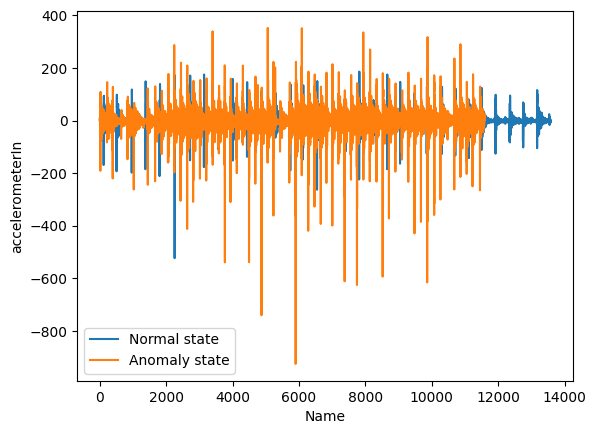

In [164]:
import seaborn as sns

sns.lineplot(data=normalState.to_pandas(), x="Name", y="accelerometerIn", label="Normal state")
sns.lineplot(data=anomalyState.to_pandas(), x="Name", y="accelerometerIn", label="Anomaly state")


In [165]:
import numpy as np

def splitTimeDataIntoBuffers(inputData, bufferLength = 200):
    numBuffers = len(inputData) // bufferLength

    buffersSplitted = []
    for i in range(numBuffers):
        buffer = np.array(inputData[i * numBuffers : (i + 1) * numBuffers, 1])
        buffersSplitted.append(buffer)

    return buffersSplitted

normalTimeBuffers = splitTimeDataIntoBuffers(normalState)
anomalyTimeBuffers = splitTimeDataIntoBuffers(anomalyState)


In [166]:
import numpy as np

columnsSpec = {
"acc_min": pl.Series([], dtype=pl.Int64),
"acc_max": pl.Series([], dtype=pl.Int64),
"acc_rms": pl.Series([], dtype=pl.Float64),
"acc_mean": pl.Series([], dtype=pl.Float64),
"class": pl.Series([], dtype=pl.Int64)
}

def calculateFeatures(inputData, targetClass):
    dfOutputFrame = pl.DataFrame(columnsSpec)

    #min, max, rms, mean
    for buf in inputData:
        acc_max = np.max(buf)
        acc_min = np.min(buf)
        acc_mean = np.mean(buf)
        acc_rms = np.sqrt(np.mean(np.square(buf)))
        
        new_row = {
            "acc_min": acc_min,
            "acc_max": acc_max,
            "acc_rms": acc_rms,
            "acc_mean": acc_mean,
            "class": targetClass
        }

        # Add the new row to the dataframe
        dfOutputFrame = dfOutputFrame.vstack(pl.DataFrame([new_row]))

    return dfOutputFrame

dfNormalLearnTestSet = calculateFeatures(normalTimeBuffers, 0)
dfAnomalyLearnTestSet = calculateFeatures(anomalyTimeBuffers, 1)

dfLearnTestSet = pl.DataFrame(columnsSpec)
dfLearnTestSet = dfLearnTestSet.vstack(dfNormalLearnTestSet)
dfLearnTestSet = dfLearnTestSet.vstack(dfAnomalyLearnTestSet)

In [167]:
dfLearnTestSet.columns

['acc_min', 'acc_max', 'acc_rms', 'acc_mean', 'class']

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

X = dfLearnTestSet[:, :4] 
y = dfLearnTestSet[:, 4]  

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
clf = MLPClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred, pos_label=1)  # Sensitivity (Recall) for positive class
specificity = recall_score(y_test, y_pred, pos_label=0)  # Recall for the negative class = Specificity
roc_auc = roc_auc_score(y_test, y_pred)  # AUC requires predicted probabilities

print(f"Classifier used: {clf}")
print(f"Accuraccies: {accuracy}")
print(f"Sensitivities (Recall for positive class): {sensitivity}")
print(f"Specificities (Recall for negative class): {specificity}")
print(f"ROC AUCs: {roc_auc}")


Classifier used: DecisionTreeClassifier()
Accuraccies: 0.84
Sensitivities (Recall for positive class): 1.0
Specificities (Recall for negative class): 0.7333333333333333
ROC AUCs: 0.8666666666666667
